<a href="https://colab.research.google.com/github/MaxenceAr/Projet_AAA_ARHOUL_REVEL/blob/main/Projet_AAA_ARHOUL_REVEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data description, load & libs install instructions



The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

The classification goal is to predict if the client will subscribe a term deposit (variable y).

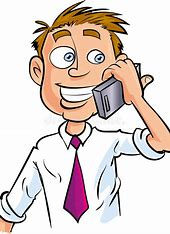

Columns :

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur", "student","blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign: 9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

output variable (desired target): 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# Importations

In [62]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
import warnings
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils.parallel import delayed
from sklearn.model_selection import GridSearchCV,KFold
import math
from sklearn.cluster import KMeans

*if you have an error message after running this cell, try the following commands, and then restart the kernel:*

!pip install --upgrade imbalanced-learn

!pip install --upgrade scikit-learn

In [63]:
marketing = fetch_openml('bank-marketing', version=1, parser='auto',as_frame=True)

In [64]:
X, y = marketing.data, marketing.target

In [65]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = pd.Series(y)

In [66]:
X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.1, random_state=42)

# Data Exploratory Analysis

In [ ]:
print(y)

14565    0
20546    0
34495    0
13814    0
42153    1
        ..
11284    1
44732    0
38158    0
860      0
15795    0
Length: 40689, dtype: int64


We can change all the '0' into 'no' (no subsribtion) et all the '1' into 'yes' (subscribtion)

In [67]:
y=y.replace({0: 'no', 1: 'yes'})

In [ ]:
print(y)

In [ ]:
X.head()

We can change column names to facilitate understanding

In [68]:
nouveaux_noms = ['age', 'job','marital','education','default','balance','housing', 'loan', 'contact', 'day','month','duration', 'campaign','pdays','previous','poutcome']
X.columns = nouveaux_noms
X_validation.columns = nouveaux_noms

In [ ]:
X.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,housemaid,married,primary,no,0,yes,no,cellular,15,jul,317,3,-1,0,unknown
20546,57,management,divorced,secondary,no,396,no,no,cellular,12,aug,108,2,-1,0,unknown


In [ ]:
print (f"il y a {y.shape} échantillons")

il y a (40689,) échantillons


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 14565 to 15795
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        40689 non-null  int64   
 1   job        40689 non-null  category
 2   marital    40689 non-null  category
 3   education  40689 non-null  category
 4   default    40689 non-null  category
 5   balance    40689 non-null  int64   
 6   housing    40689 non-null  category
 7   loan       40689 non-null  category
 8   contact    40689 non-null  category
 9   day        40689 non-null  int64   
 10  month      40689 non-null  category
 11  duration   40689 non-null  int64   
 12  campaign   40689 non-null  int64   
 13  pdays      40689 non-null  int64   
 14  previous   40689 non-null  int64   
 15  poutcome   40689 non-null  category
dtypes: category(9), int64(7)
memory usage: 2.8 MB


There are not any missing values.
There are 7 numeric columns and 9 categorical columns.

The "day" variable (day of the month of the last contact) is ordinal. We can choose to keep it numeric or convert it to categorical. We tried to convert it to categorical (depending on whether the last contact was after the 25th of the month (end of mont) or before (beginning of month)). But this reduced the recall of our random forest model by 1%. So we decided to keep the 'day' variable numeric.

## Look at categorical values

In [69]:
cat_features=["job","marital","education","default","housing","loan","contact","month","poutcome"]

Text(0.5, 1.0, 'target')

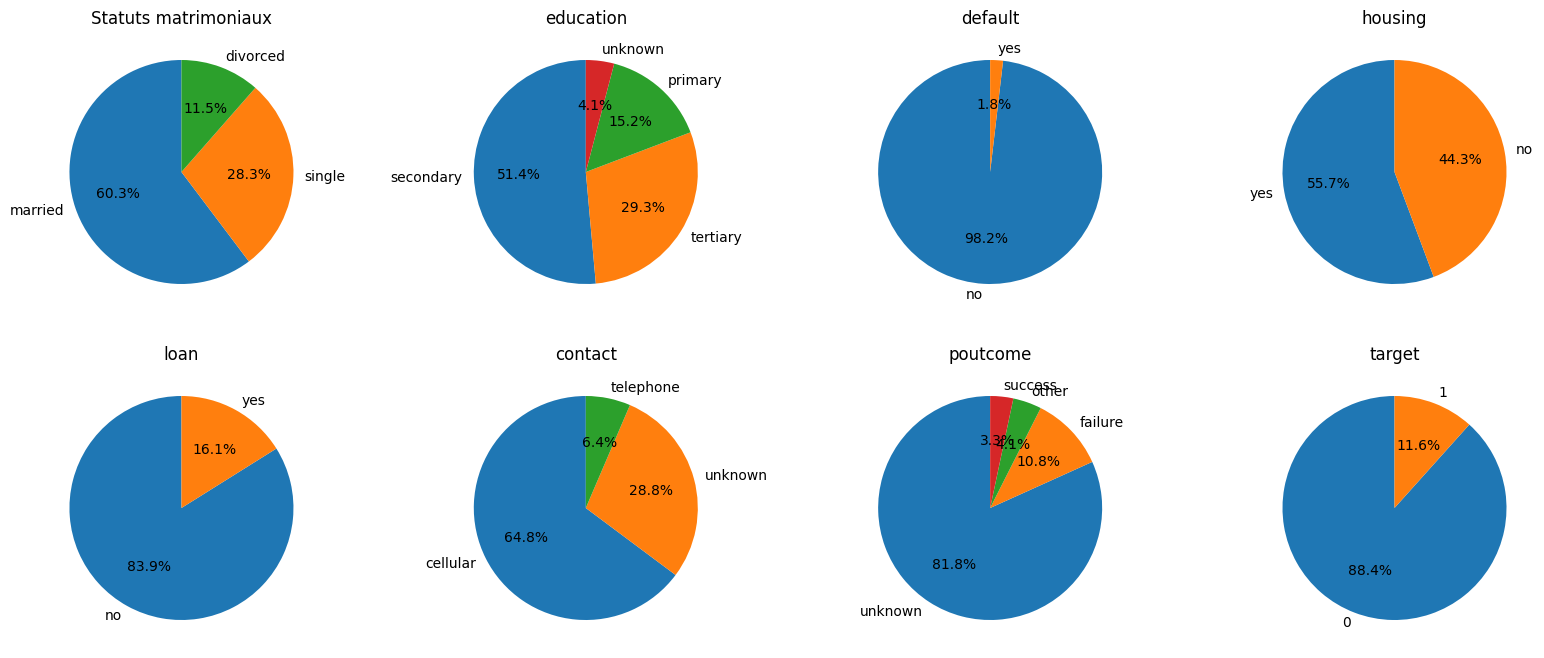

In [ ]:
comptage_marital = X['marital'].value_counts()
etiquettes_marital = comptage_marital.index
valeurs_marital = comptage_marital.values

comptage_education = X['education'].value_counts()
etiquettes_education=comptage_education.index
valeurs_education=comptage_education

comptage_default = X['default'].value_counts()
etiquettes_default=comptage_default.index
valeurs_default=comptage_default.values

comptage_housing = X['housing'].value_counts()
etiquettes_housing=comptage_housing.index
valeurs_housing=comptage_housing.values

comptage_loan = X['loan'].value_counts()
etiquettes_loan=comptage_loan.index
valeurs_loan=comptage_loan.values

comptage_contact = X['contact'].value_counts()
etiquettes_contact=comptage_contact.index
valeurs_contact=comptage_contact.values

comptage_poutcome = X['poutcome'].value_counts()
etiquettes_poutcome=comptage_poutcome.index
valeurs_poutcome=comptage_poutcome.values

comptage_target = y.value_counts()
etiquettes_target=comptage_target.index
valeurs_target=comptage_target.values


# Créez la figure avec une grille de sous-graphiques
fig, axs = plt.subplots(2, 4, figsize=(20, 8))  # 1 ligne, 2 colonnes (2 graphiques côte à côte)

#first sub figure
axs[0,0].pie(valeurs_marital, labels=etiquettes_marital, autopct='%1.1f%%', startangle=90)
axs[0,0].set_title('Statuts matrimoniaux')

#second sub figure
axs[0,1].pie(valeurs_education, labels=etiquettes_education, autopct='%1.1f%%', startangle=90)
axs[0,1].set_title('education')

#third sub figure
axs[0,2].pie(valeurs_default, labels=etiquettes_default, autopct='%1.1f%%', startangle=90)
axs[0,2].set_title('default')

axs[0,3].pie(valeurs_housing, labels=etiquettes_housing, autopct='%1.1f%%', startangle=90)
axs[0,3].set_title('housing')

axs[1,0].pie(valeurs_loan, labels=etiquettes_loan, autopct='%1.1f%%', startangle=90)
axs[1,0].set_title('loan')

axs[1,1].pie(valeurs_contact, labels=etiquettes_contact, autopct='%1.1f%%', startangle=90)
axs[1,1].set_title('contact')

axs[1,2].pie(valeurs_poutcome, labels=etiquettes_poutcome, autopct='%1.1f%%', startangle=90)
axs[1,2].set_title('poutcome')

axs[1,3].pie(valeurs_target, labels=etiquettes_target, autopct='%1.1f%%', startangle=90)
axs[1,3].set_title('target')







Our dataframe is a little unbalanced (88% of no, and 12% of yes). Half of our non-numeric features are binary, and the rest have few different values.

In [ ]:
X['job'].value_counts()

blue-collar      8752
management       8505
technician       6853
admin.           4637
services         3757
retired          2047
self-employed    1436
entrepreneur     1328
unemployed       1158
housemaid        1121
student           841
unknown           254
Name: job, dtype: int64

In [ ]:
X['month'].value_counts()

may    12414
jul     6182
aug     5612
jun     4811
nov     3577
apr     2640
feb     2374
jan     1268
oct      665
sep      521
mar      423
dec      202
Name: month, dtype: int64

Let's now look at the distribution of our categorical variables according to their class.

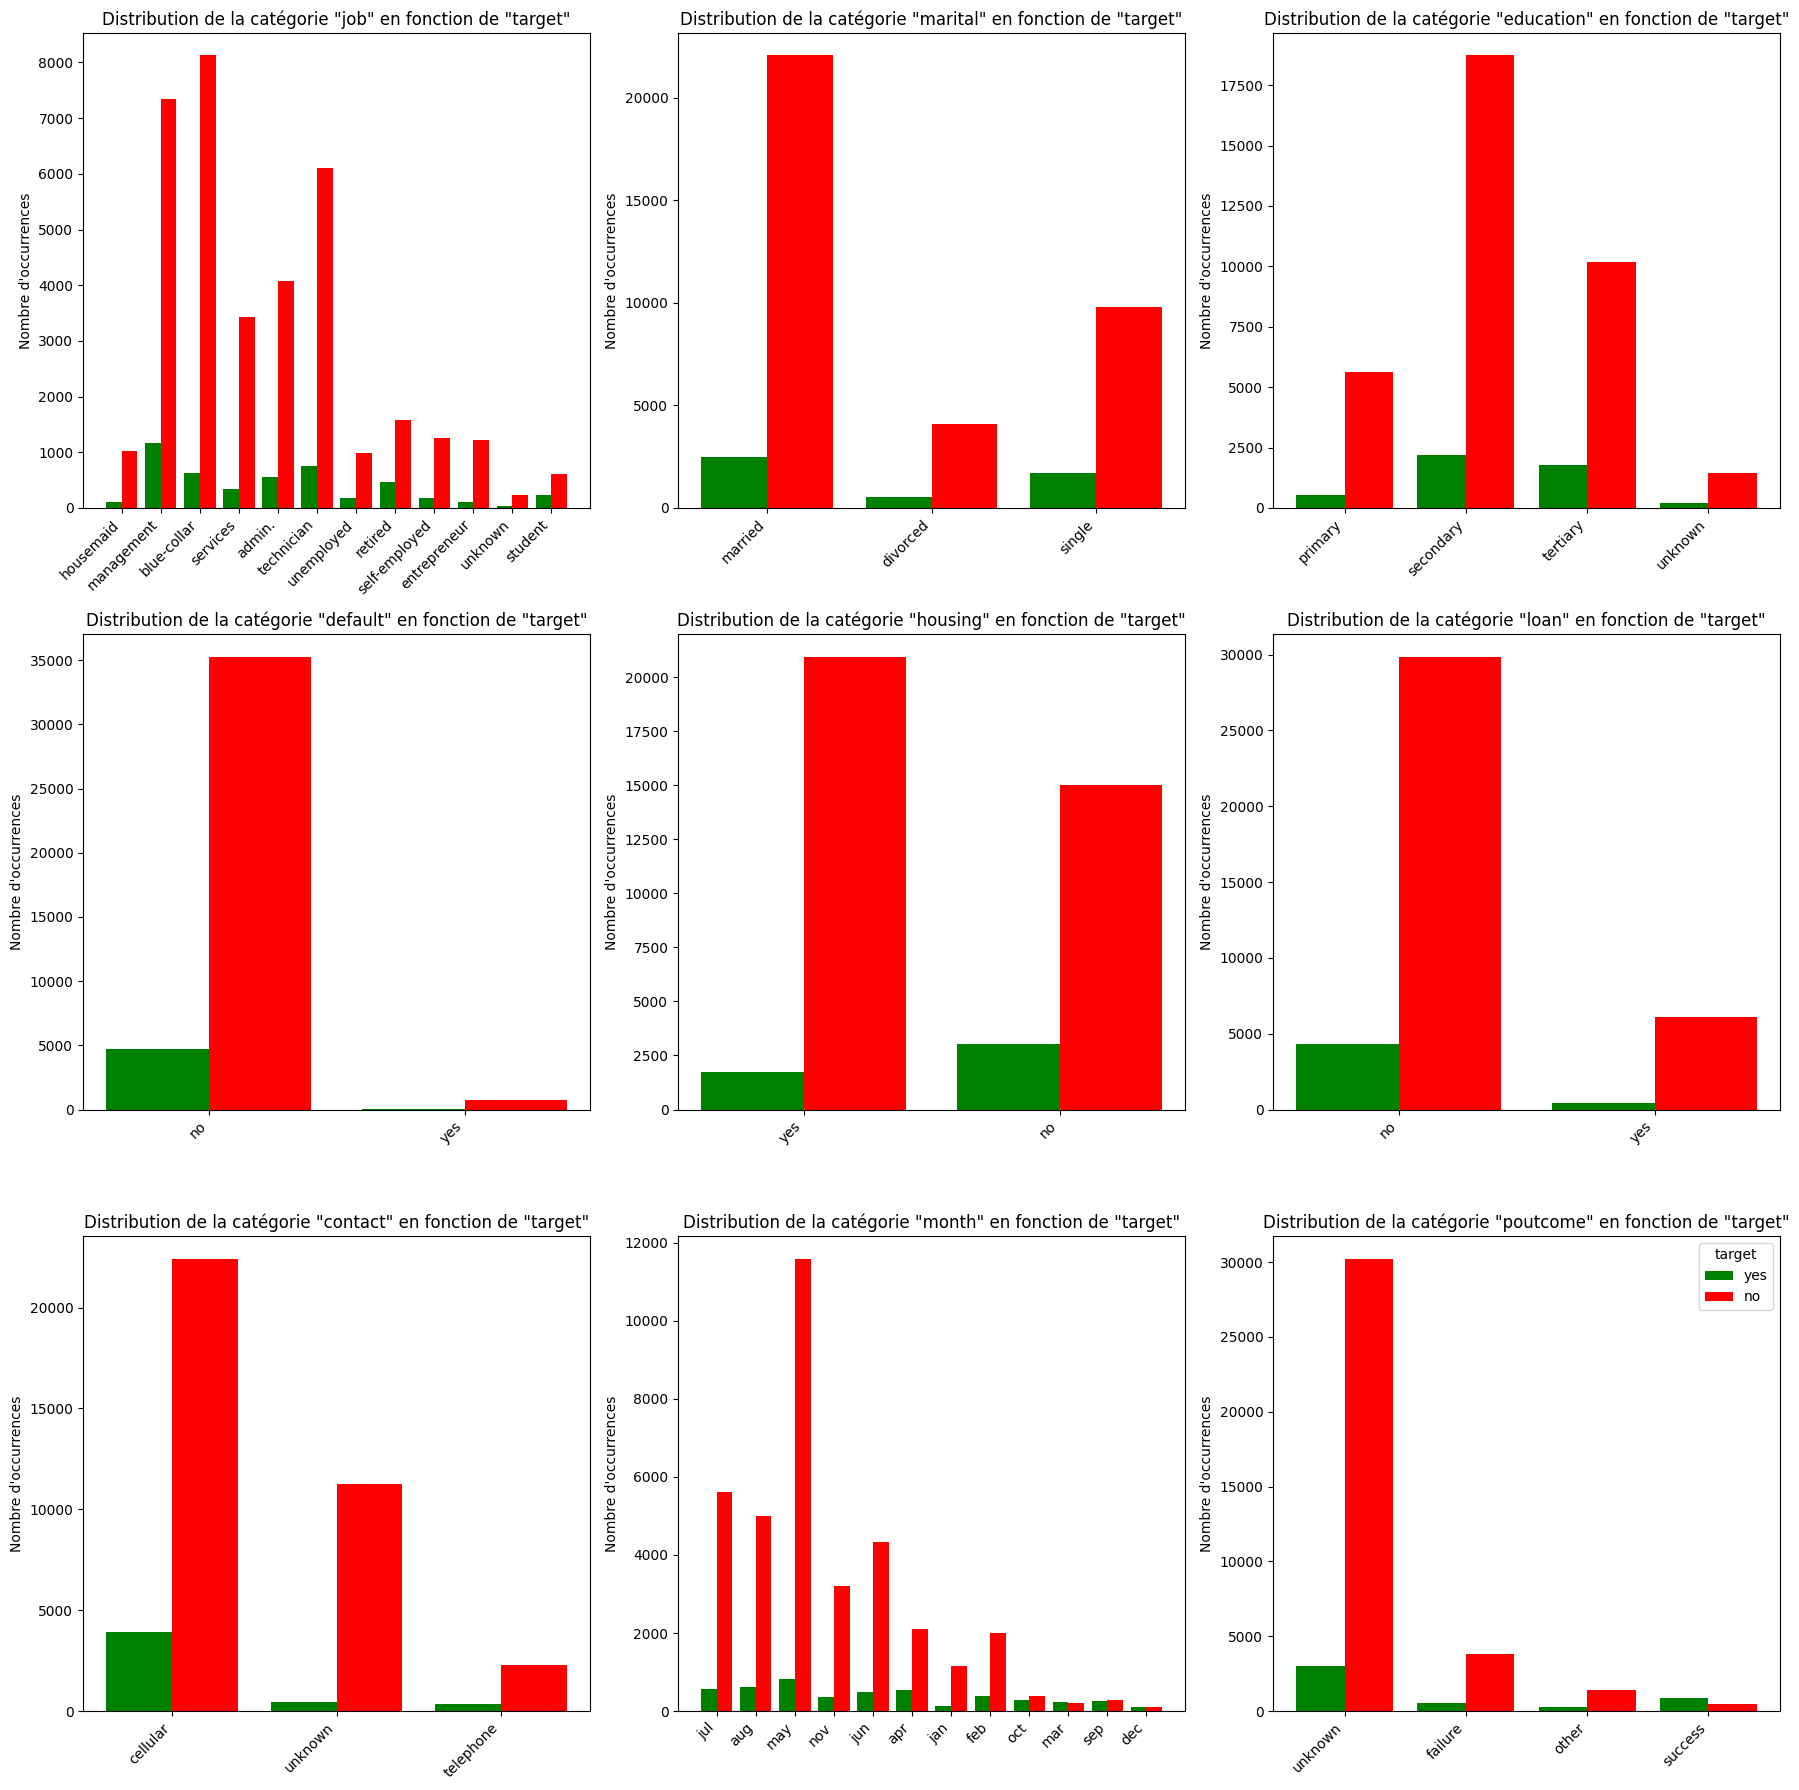

In [71]:
import matplotlib.pyplot as plt
import numpy as np
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
#y_encoded has the same informations than y, but in y_encoded 1 corresponds to 'yes', and 0 to 'no'. We do that because Balance Random Forest can manage only target with 0 and 1.

# Liste des colonnes catégorielles à visualiser
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

# Créez une figure avec une grille de sous-graphiques
fig, axs = plt.subplots(3, 3, figsize=(18, 18))  # 3 lignes, 3 colonnes (9 graphiques au total)

# Boucle à travers les colonnes catégorielles
for i, column in enumerate(categorical_columns):
    # Exemple de données (assurez-vous que vos données contiennent des occurrences de chaque catégorie pour 'yes' et 'no')
    categories = X[column].unique()
    values_yes = X.loc[y_encoded == 1, column].value_counts().reindex(categories, fill_value=0)
    values_no = X.loc[y_encoded == 0, column].value_counts().reindex(categories, fill_value=0)

    # Initialisez les positions des barres
    positions = np.arange(len(categories))

    # Tracez les barres pour la catégorie 'yes'
    bars_yes = axs[i // 3, i % 3].bar(positions - 0.2, values_yes, width=0.4, color='green', label='yes')

    # Tracez les barres pour la catégorie 'no'
    bars_no = axs[i // 3, i % 3].bar(positions + 0.2, values_no, width=0.4, color='red', label='no')

    # Ajoutez des étiquettes et des titres
    axs[i // 3, i % 3].set_xticks(positions)
    axs[i // 3, i % 3].set_xticklabels(categories, rotation=45, ha="right")
    axs[i // 3, i % 3].set_ylabel('Nombre d\'occurrences')
    axs[i // 3, i % 3].set_title(f'Distribution de la catégorie "{column}" en fonction de "target"')

# Ajoutez une légende pour les couleurs
axs[2, 2].legend(title='target')

# Ajustez l'espacement entre les sous-graphiques
fig.tight_layout()

# Affichez le graphique
plt.show()


For each category of each variable, there are more "no" classes than "yes" classes. This is not surprising as our dataset is unbalanced.

## Look at numeric values

In [ ]:
num_features=["age","balance","day", "duration","campaign","pdays","previous"]

In [ ]:
X.describe()

,age,balance,day,duration,campaign,pdays,previous
count,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000
mean,40.948438,1363.834599,15.823834,257.409152,2.763007,40.178500,0.576937
std,10.629355,3076.432085,8.320641,256.902540,3.115753,100.181205,2.311883
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,71.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,447.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


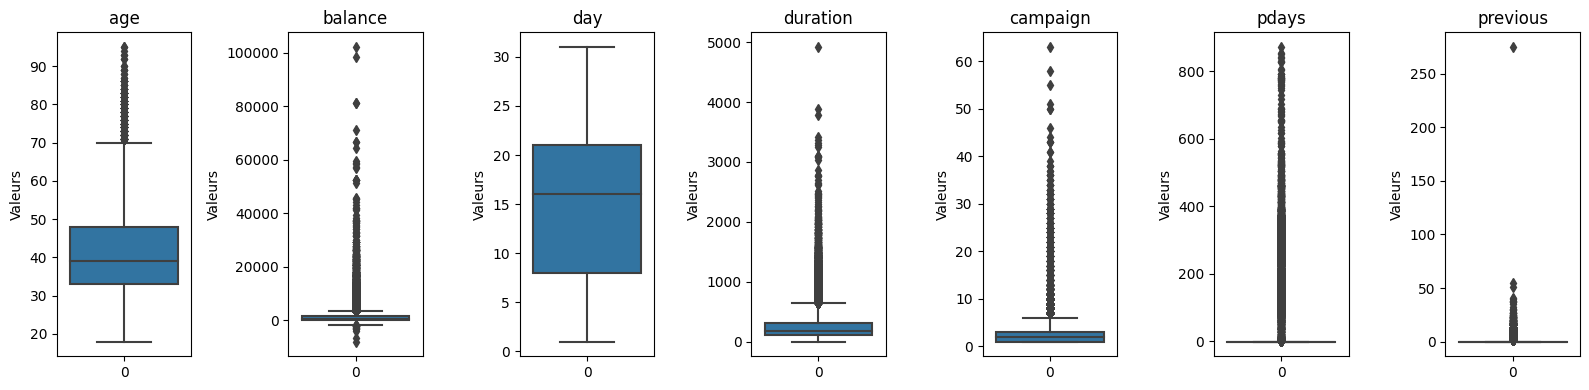

In [ ]:
fig, axes = plt.subplots(1, 7, figsize=(16, 4))  # 1 ligne, 7 colonnes
for i, col in enumerate(X[num_features].columns):
    sns.boxplot(data=X[num_features][col], orient="v", ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Valeurs')

# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez les sous-graphiques
plt.show()

The vast majority of customers have never been contacted before.
Besides, we can see that there are a lot of outliers. Let's look at what happens if we remove the 10% most extreme values.

In [ ]:
clf = IsolationForest(contamination=0.1)
outliers = clf.fit_predict((X[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']]))
X_no_outliers = X[outliers != -1]
y_no_outliers = y[outliers != -1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


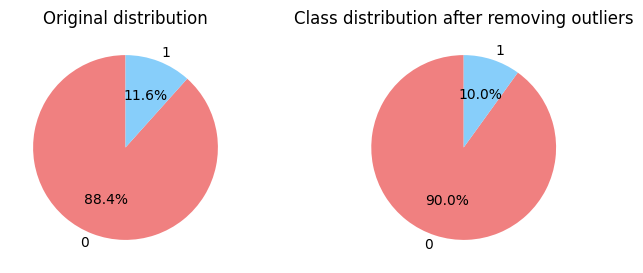

In [ ]:
class_counts_original = y.value_counts()

class_counts_no_outliers = y_no_outliers.value_counts()


fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Pie chart pour y
axes[0].pie(class_counts_original, labels=class_counts_original.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
axes[0].set_title('Original distribution')

# Pie chart pour y_no_outliers
axes[1].pie(class_counts_no_outliers, labels=class_counts_no_outliers.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
axes[1].set_title('Class distribution after removing outliers')


plt.show()



Deleting the outliers further reduces the share of the "yes" class. So we will keep them for the rest of this work.

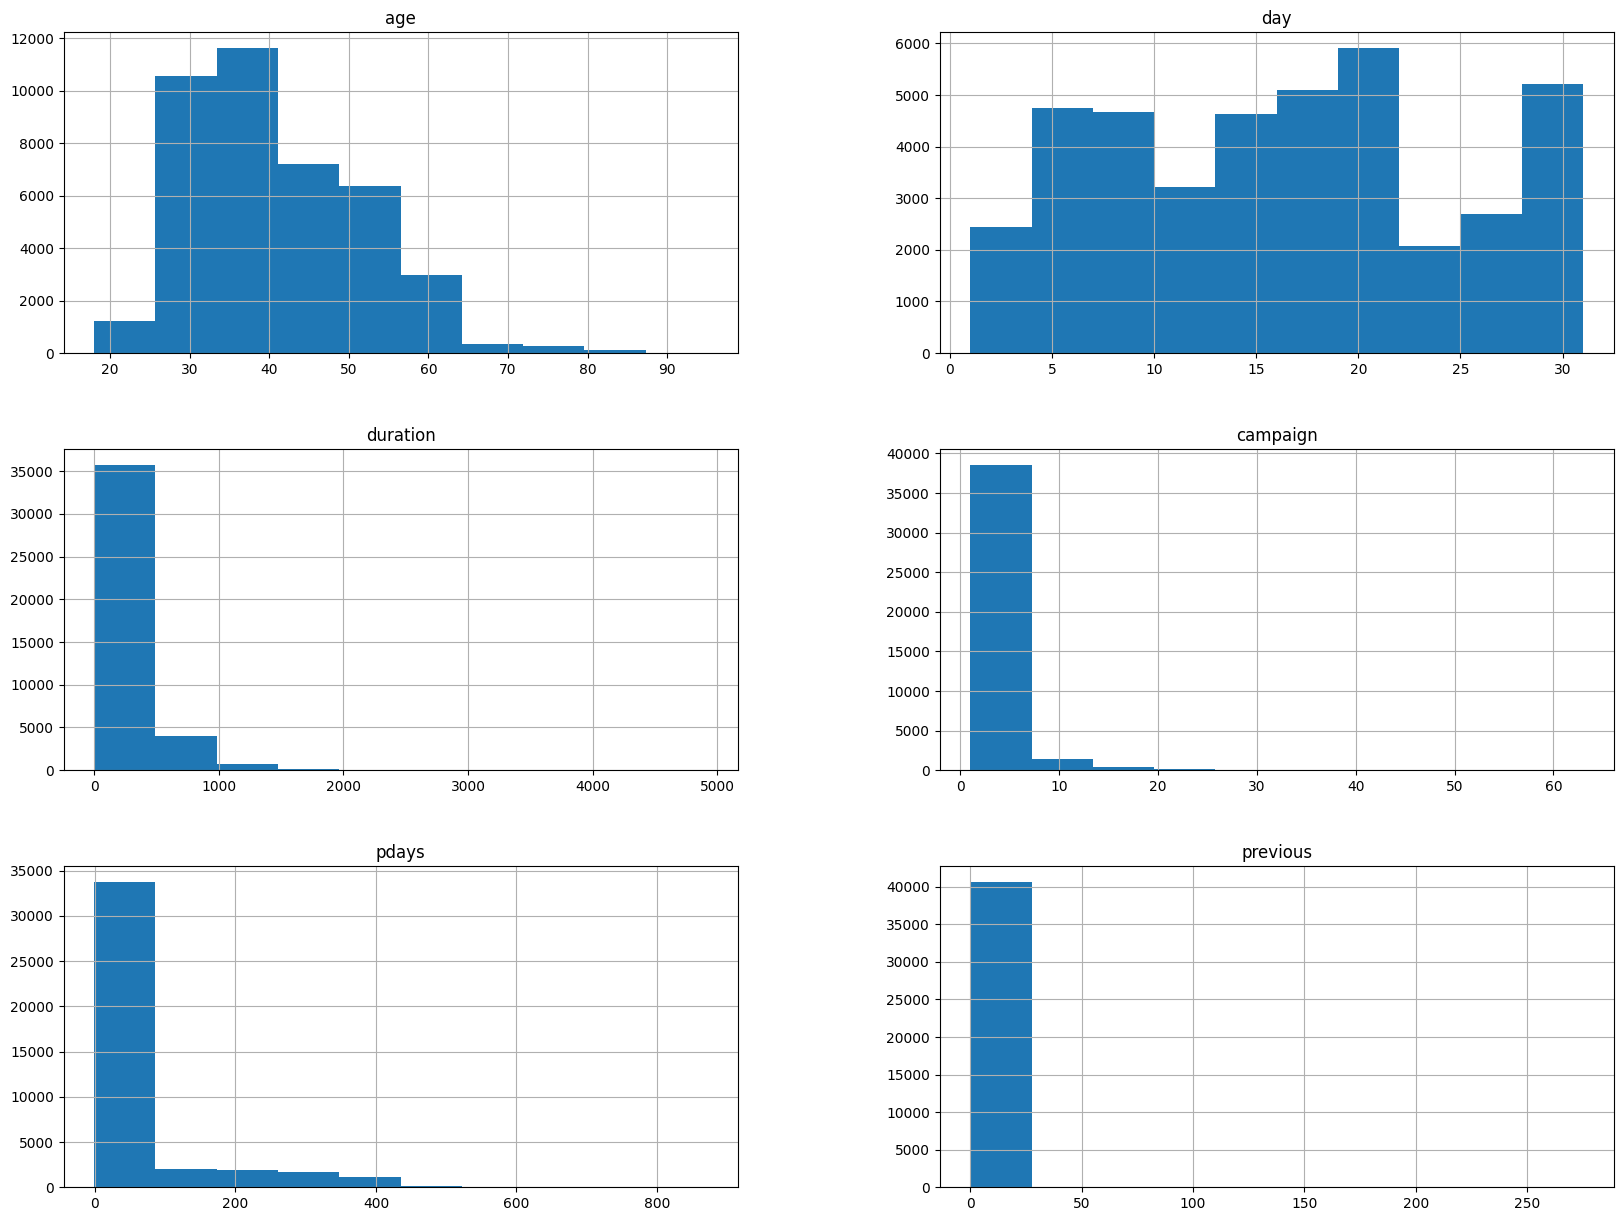

In [ ]:
X_without_balance=X.drop('balance', axis=1)
X_without_balance.hist(figsize=(20,15))
plt.show()

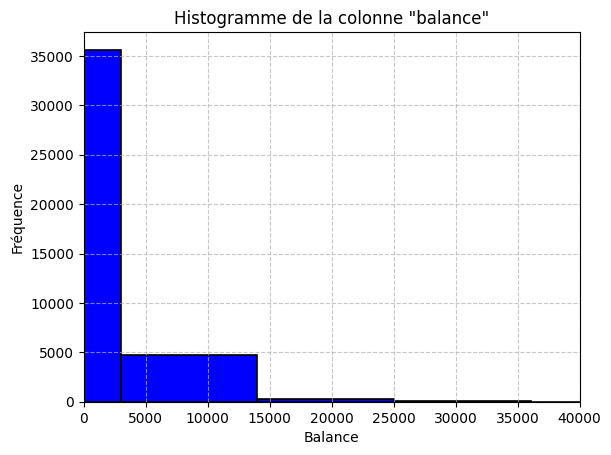

In [ ]:
plt.hist(X['balance'], bins=10, color='blue', edgecolor='black', linewidth=1.2)
plt.title('Histogramme de la colonne "balance"')
plt.xlabel('Balance')
plt.ylabel('Fréquence')
plt.xlim(0, 40000)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

None of the columns are capped.

Now, we will have to scale our data when features exhibit different orders of magnitude to ensure a balanced influence in machine learning models and mitigate biases associated with disparate scales.

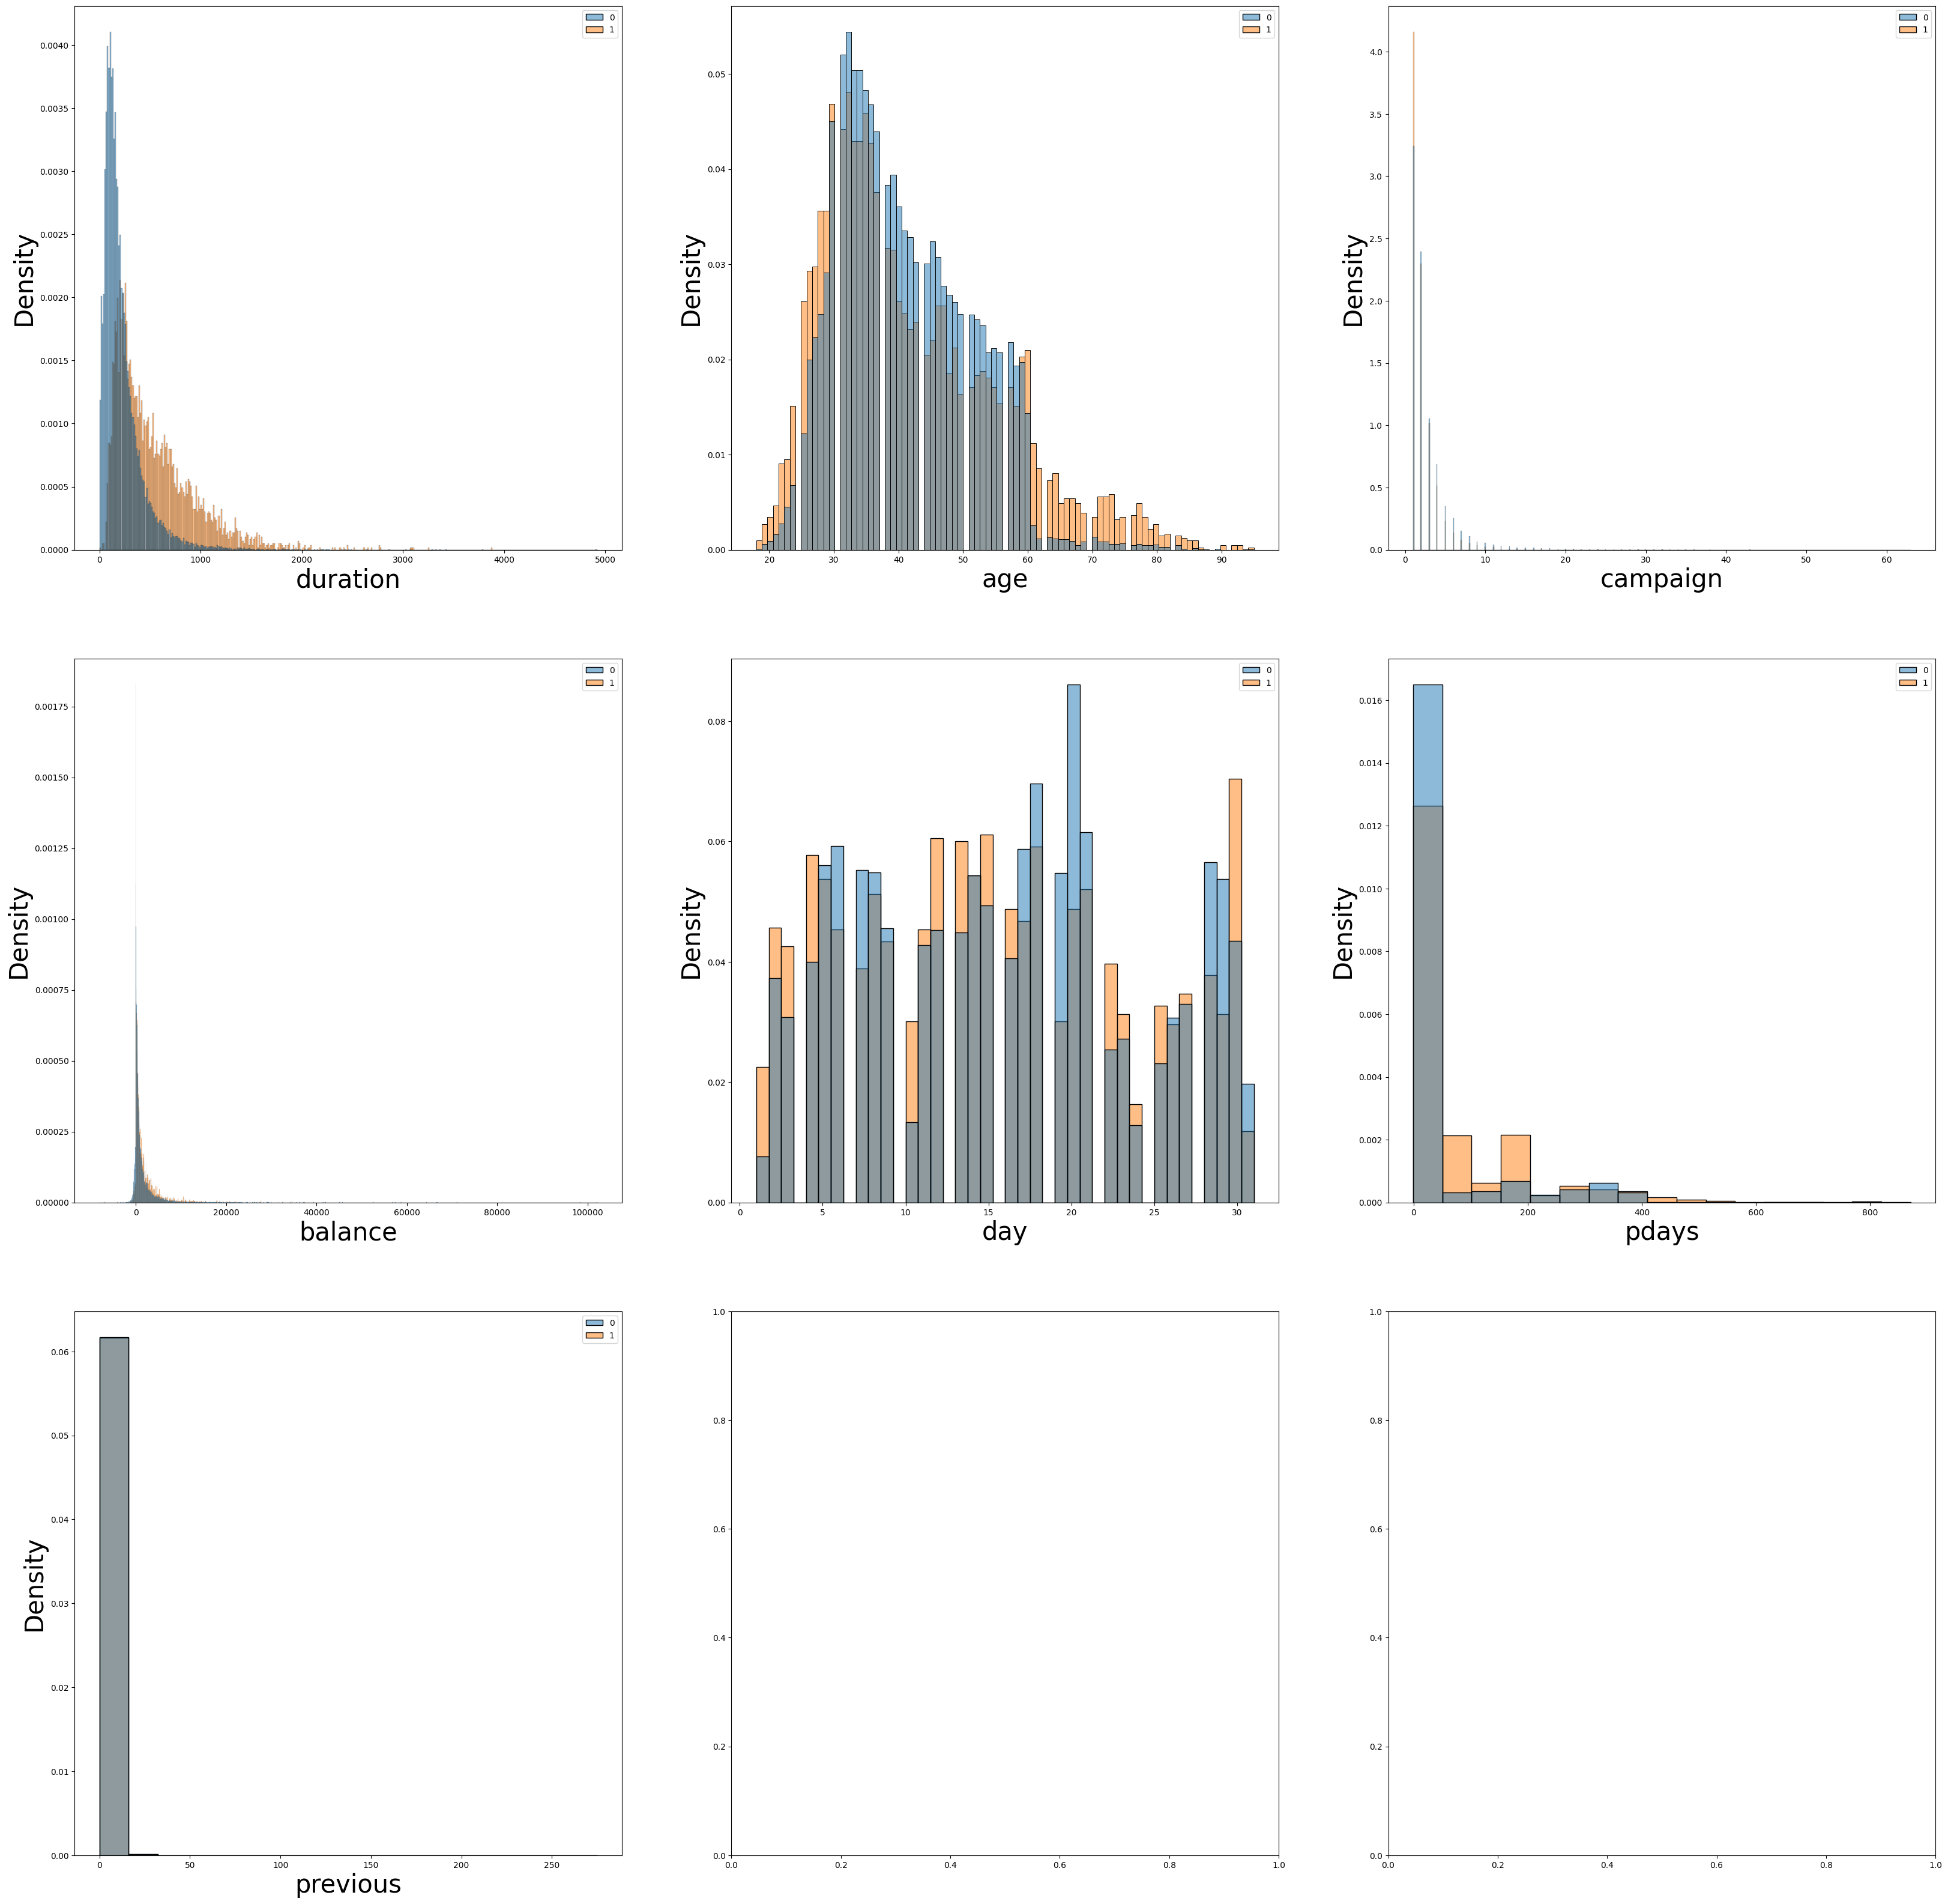

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(40, 40))  # Ajustez figsize selon vos besoins


sns.histplot(data=X, x='duration', hue=y, stat="density", common_norm=False,ax=axs[0,0])
sns.histplot(data=X, x='age', hue=y, stat="density", common_norm=False,ax=axs[0,1])
sns.histplot(data=X, x='campaign', hue=y, stat="density", common_norm=False,ax=axs[0,2])
sns.histplot(data=X, x='balance', hue=y, stat="density", common_norm=False,ax=axs[1,0])
sns.histplot(data=X, x='day', hue=y, stat="density", common_norm=False, ax=axs[1,1])
sns.histplot(data=X, x='pdays', hue=y, stat="density", common_norm=False,ax=axs[1,2])
sns.histplot(data=X, x='previous', hue=y, stat="density", common_norm=False,ax=axs[2,0])

for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)


plt.show()

The "duration" column shows a clear trend, as there is little overlap between "yes" and "no". The same applies to the balance column. With the histogram of the age column, we can see that over a certain age, the "yes" rate is much higher, but this concerns very few people.

Now, we can check correlations to see wether somme colums hold the same information. If it is the case, we could remove them.

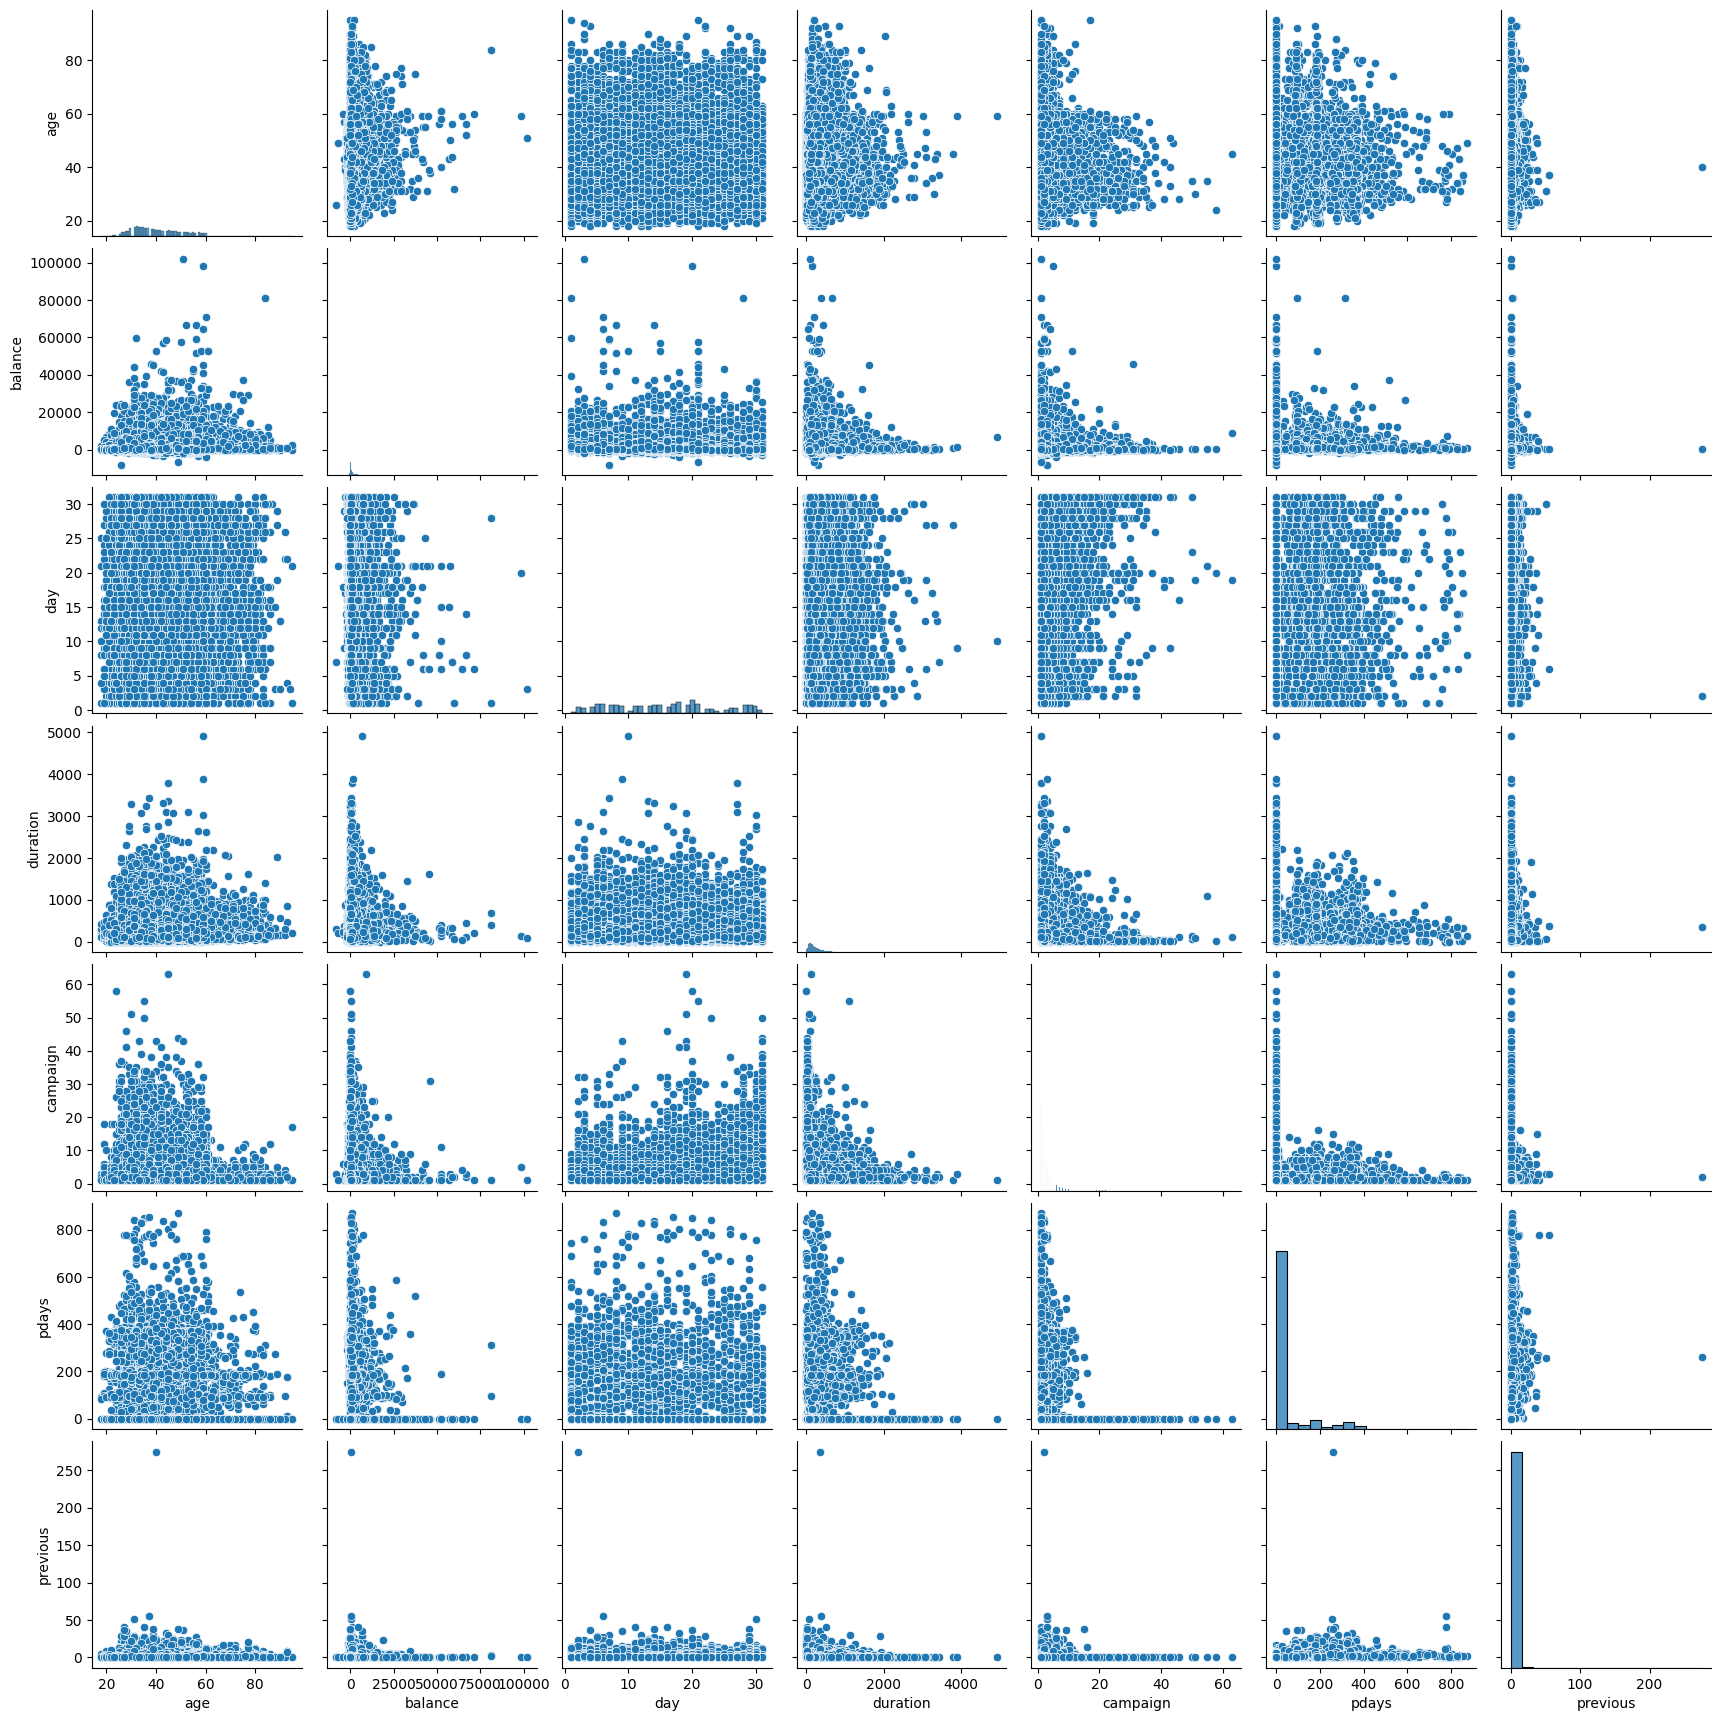

In [ ]:
sns.pairplot(X)

We can also check it with the correlation matrix.
(comments on correlations will be found below)

               age   balance       day  duration  campaign     pdays  previous
age       1.000000  0.098095 -0.009860 -0.004244  0.004599 -0.025539  0.001345
balance   0.098095  1.000000  0.002664  0.023202 -0.016263  0.001526  0.014048
day      -0.009860  0.002664  1.000000 -0.027466  0.159956 -0.094592 -0.053121
duration -0.004244  0.023202 -0.027466  1.000000 -0.085371 -0.001975  0.002271
campaign  0.004599 -0.016263  0.159956 -0.085371  1.000000 -0.088286 -0.033794
pdays    -0.025539  0.001526 -0.094592 -0.001975 -0.088286  1.000000  0.449060
previous  0.001345  0.014048 -0.053121  0.002271 -0.033794  0.449060  1.000000


<Axes: >

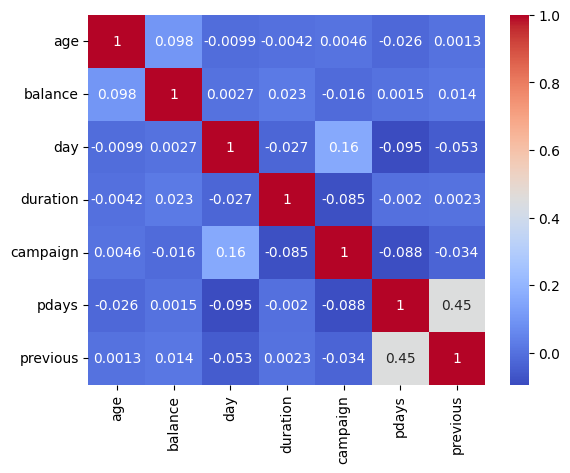

In [ ]:
correlation_matrix = X[num_features].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

There is a correlation between pdays and previous
This was to be expected. Indeed, if previous is -1 (the customer had never been contacted in a previous campaign), pdays (the number of days before the last contact in a previous campaign) is necessarily 0.

There's also a slight correlation between day (day of month of last contact) and campaign (number of times the customer was contacted during the campaign). This is easy to understand. If a campaign starts at the beginning of the month, for example, a customer is more likely to have been contacted several times at the end of the month than at the beginning.

Finally, there is a little correlation between between balance (amount of money in the account) and age. It's not surprising, because we know that young people generally have less money than older people.

# Unsupervised Exploration

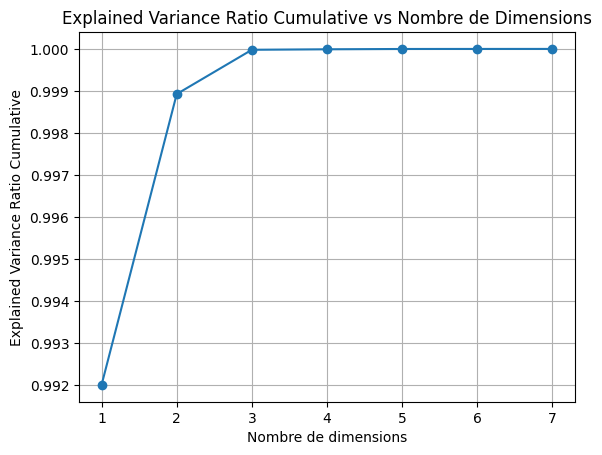

        age   balance       day  duration  campaign     pdays  previous
0  0.000339  0.999998  0.000007  0.001951 -0.000016  0.000050  0.000011
1 -0.000271 -0.001951 -0.000892  0.999997 -0.001031 -0.000923  0.000016
2 -0.002757 -0.000051 -0.007917  0.000912 -0.002757  0.999907  0.010366
3  0.999653 -0.000339 -0.026065  0.000249  0.000097  0.002521  0.002707
4  0.025989 -0.000017  0.997495  0.000972  0.065210  0.008178 -0.002903
5 -0.001833  0.000015 -0.065167  0.000972  0.997803  0.002109  0.011571
6 -0.002581 -0.000009  0.003803 -0.000035 -0.011329 -0.010374  0.999871


In [ ]:
pca = PCA()
X_num = X[num_features]

X_pca = pca.fit_transform(X_num)


explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o')
plt.xlabel('Nombre de dimensions')
plt.ylabel('Explained Variance Ratio Cumulative')
plt.title('Explained Variance Ratio Cumulative vs Nombre de Dimensions')
plt.grid(True)
plt.show()


components = pca.components_
components_df = pd.DataFrame(components, columns=num_features)
print(components_df)

We can see that the variance reaches 1 from 3 dimensions upwards, so we can deduce that some features provide little information. If we look at the weight of the features in the dimensions, it confirms that the 'campagn', 'day' and 'previous' columns provide us with very little information (this can be seen in the other graphs that have been produced).

In fact, the most interesting part of the information is contained in two variables: 'balance' and 'duration'.

We will now see if the 'duration' and 'balance' variables can be used to naturally group the data into two distinct clusters, and then compare these clusters with the true labels to assess the performance of the clustering. This may give some indication of the separability of the classes in the chosen feature space.


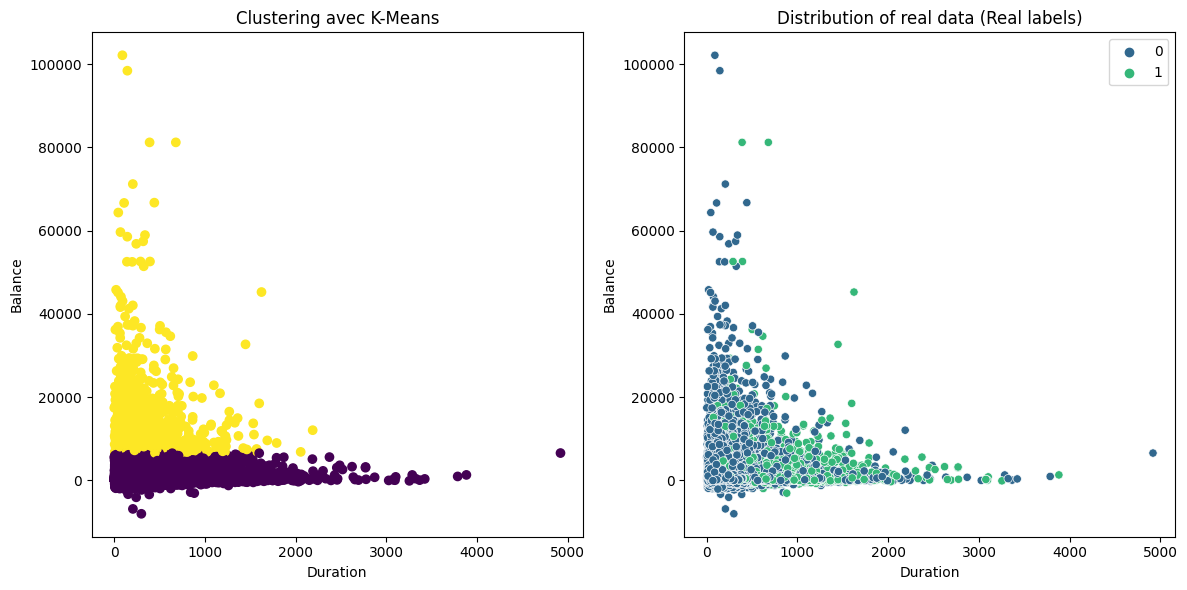

In [ ]:
# Utilisez l'algorithme de K-Means pour prédire les clusters
num_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

# Sélectionnez uniquement les colonnes de la liste num_features
selected_features = X[num_features]


kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
labels = kmeans.fit_predict(selected_features)
# Graphe 1 (K-Means)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X['duration'], X['balance'], c=labels, cmap='viridis')
plt.title('Clustering avec K-Means')
plt.xlabel('Duration')
plt.ylabel('Balance')

# Graphe 2 (Vraies étiquettes)
plt.subplot(1, 2, 2)
sns.scatterplot(x=X['duration'], y=X['balance'], hue=y, palette='viridis', legend='full')
plt.title('Distribution of real data (Real labels)')
plt.xlabel('Duration')
plt.ylabel('Balance')

# Ajustez l'espace entre les graphes pour éviter le chevauchement
plt.tight_layout()

# Affiche les graphes
plt.show()

Taking the 2 dimensions (equivalent to features) with the highest variance (almost equal to 1 cumulatively, hence very representative of the dataset), we do not find meaningful clusters. This means that our data has a more complex structure than we might have thought.

#Data Preparation

In [ ]:
#KNN Classifier and Regression Logistic
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

#random forest
numerical_transformer_whithout_scaler = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),

])

categorical_transformer_without_one_hot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocessor_just_imput = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_whithout_scaler, num_features),
        ('cat', categorical_transformer, cat_features)
    ])



# ML Baseline Models

We will try the following models : KNN Classifier, Regression Logistic and Random Forest Classifier.

In [ ]:
knn_clf = KNeighborsClassifier()
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_clf)
])

logistic_regression = LogisticRegression(max_iter=5000)


pipeline_reg_logi = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_regression)
])

In [ ]:
rdm_forest_clf=RandomForestClassifier()
pipeline_rdm_forest=Pipeline(steps=[('prepo',preprocessor_just_imput),('classifier',rdm_forest_clf)])
#the goal of the next line is to delete a warning whithout interests tied to brf_model
warnings.filterwarnings("ignore")
brf_model = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy='auto', replacement=False, random_state=42)
pipeline_brf=Pipeline(steps=[('prepo',preprocessor_just_imput),('classifier',brf_model)])

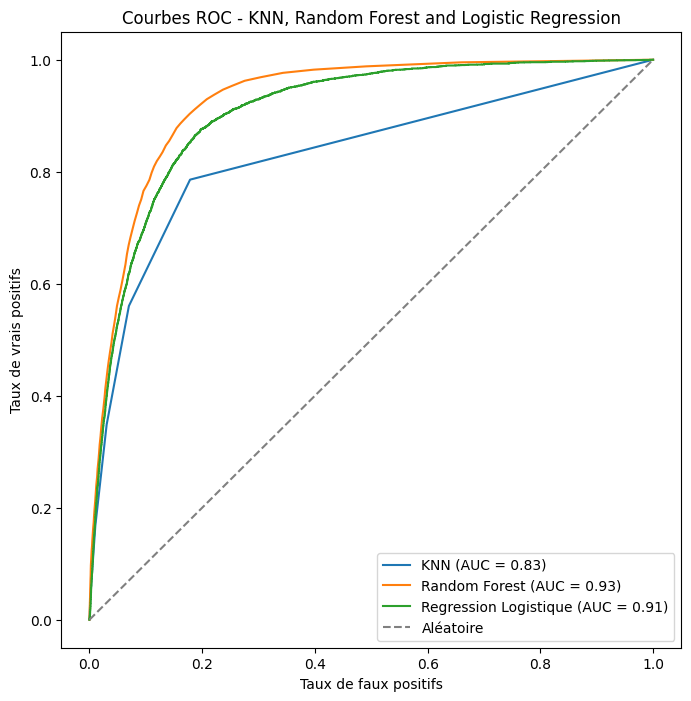

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# Effectuez la validation croisée en utilisant l'AUC-ROC comme métrique
y_probas_knn = cross_val_predict(pipeline_knn, X, y_encoded, cv=cv, method='predict_proba')
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_encoded, y_probas_knn[:, 1], pos_label=1)
roc_auc_knn = auc(fpr_knn, tpr_knn)

y_probas_rdm_forest = cross_val_predict(pipeline_rdm_forest, X, y_encoded, cv=cv, method='predict_proba')
fpr_rdm_forest, tpr_rdm_forest, thresholds_rdm_forest = roc_curve(y_encoded, y_probas_rdm_forest[:, 1], pos_label=1)
roc_auc_rdm_forest = auc(fpr_rdm_forest, tpr_rdm_forest)

y_probas_reg_logi = cross_val_predict(pipeline_reg_logi, X, y_encoded, cv=cv, method='predict_proba')
fpr_reg_logi, tpr_reg_logi, thresholds_reg_logi = roc_curve(y_encoded, y_probas_reg_logi[:, 1], pos_label=1)
roc_auc_tree = auc(fpr_reg_logi, tpr_reg_logi)




# Tracer les courbes ROC pour KNN et Random Forest sur la même figure
plt.figure(figsize=(8, 8))
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = {:.2f})'.format(roc_auc_knn))
plt.plot(fpr_rdm_forest, tpr_rdm_forest, label='Random Forest (AUC = {:.2f})'.format(roc_auc_rdm_forest))
plt.plot(fpr_reg_logi, tpr_reg_logi, label='Regression Logistique (AUC = {:.2f})'.format(roc_auc_tree))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Aléatoire')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC - KNN, Random Forest and Logistic Regression')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import make_scorer, f1_score

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Utilisez make_scorer pour définir le rappel comme métrique de score
scorer =make_scorer(accuracy_score)  # Assurez-vous de spécifier le pos_label approprié

# Effectuez la validation croisée en utilisant le rappel comme métrique
accuracy_scores_knn = cross_val_score(pipeline_knn,X , y, cv=cv, scoring=scorer)
accuracy_scores_rdm_forest = cross_val_score(pipeline_rdm_forest,X , y, cv=cv, scoring=scorer)
accuracy_scores_reg_logi= cross_val_score(pipeline_reg_logi,X , y, cv=cv, scoring=scorer)


mean_accuracy_knn = accuracy_scores_knn.mean()
mean_accuracy_rdm_forest = accuracy_scores_rdm_forest.mean()
mean_accuracy_reg_logi = accuracy_scores_reg_logi.mean()




print("mean accuracy of KNN on all cross validations:", mean_accuracy_knn)
print("mean accuracy of Logistitc Regression on all cross validations:", mean_accuracy_reg_logi)
print("mean accuracy of Random Forest on all cross validations:", mean_accuracy_rdm_forest)


scorer_f1 = make_scorer(f1_score, pos_label=1)


# Effectuez la validation croisée en utilisant le F-score comme métrique
f1_scores_knn = cross_val_score(pipeline_knn, X, y_encoded, cv=cv, scoring=scorer_f1)
f1_scores_rdm_forest = cross_val_score(pipeline_rdm_forest, X, y_encoded, cv=cv, scoring=scorer_f1)
f1_scores_reg_logi = cross_val_score(pipeline_reg_logi, X, y_encoded, cv=cv, scoring=scorer_f1)

# Calculer la moyenne des F-scores
mean_f1_knn = f1_scores_knn.mean()
mean_f1_rdm_forest = f1_scores_rdm_forest.mean()
mean_f1_reg_logi = f1_scores_reg_logi.mean()

# Afficher les résultats
print("Mean F1 score of KNN on all cross validations:", mean_f1_knn)
print("Mean F1 score of Logistic Regression on all cross validations:", mean_f1_reg_logi)
print("Mean F1 score of Random Forest on all cross validations:", mean_f1_rdm_forest)

mean accuracy of KNN on all cross validations: 0.8972203789722037
mean accuracy of Logistitc Regression on all cross validations: 0.9022340190223401
mean accuracy of Random Forest on all cross validations: 0.9062154390621545
Mean F1 score of KNN on all cross validations: 0.4409731803567485
Mean F1 score of Logistic Regression on all cross validations: 0.450640301302073
Mean F1 score of Random Forest on all cross validations: 0.4929271677555378


The accuracies are good, but since the dataset is unbalanced, it is not very representative of the actual effectiveness of the algorithm.The F1 score is more representative. A F1 score near 50% like that of Random Forest means that for a correct positive prediction, the model makes two errors (false negative or false positive).

Yet, in our case, the recall (proportion of people who open an account according model among those who have really opened an account) is more relevent than the accuracy. Let's check it :



In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Utilisez make_scorer pour définir le rappel comme métrique de score
scorer = make_scorer(recall_score, pos_label=1)  # Assurez-vous de spécifier le pos_label approprié

# Effectuez la validation croisée en utilisant le rappel comme métrique
recall_scores_reg_logi = cross_val_score(pipeline_reg_logi,X , y_encoded, cv=cv, scoring=scorer)
recall_scores_knn = cross_val_score(pipeline_knn,X , y_encoded, cv=cv, scoring=scorer)
recall_scores_rdm_forest = cross_val_score(pipeline_rdm_forest,X , y_encoded, cv=cv, scoring=scorer)




mean_recall_reg_logi = recall_scores_reg_logi.mean()
mean_recall_knn = recall_scores_knn.mean()
mean_recall_rdm_forest = recall_scores_rdm_forest.mean()





print("Mean recall of KNN on all cross validations:", mean_recall_knn)
print("Mean recall of Logistic Regression Rappel moyen de la régression logique on all cross validations:", mean_recall_reg_logi)
print("Mean recall of Random Forest on all cross validations:", mean_recall_rdm_forest)




Mean recall of KNN on all cross validations: 0.34846821117792065
Mean recall of Logistic Regression Rappel moyen de la régression logique on all cross validations: 0.34466873917890956
Mean recall of Random Forest on all cross validations: 0.3837374411136021


Our three models have bad recalls.


This is due to the fact that our dataset is unbalanced.


However, the random forest model performs better, so let's see how we can improve its performance.
One method is to use a Balanced Random Forest.
Balanced Random Forest is a Random Forest that manages weights to compensate the class imbalance, and over-samples the minority class.

In [ ]:
scorerWeight = make_scorer(recall_score, pos_label=1)
recall_scores_brf_model = cross_val_score(pipeline_brf,X , y_encoded, cv=cv, scoring=scorerWeight)
mean_recall_brf_model = recall_scores_brf_model.mean()
print("Mean recall of brf on all cross validations:", mean_recall_brf_model)

Mean recall of brf on all cross validations: 0.8935557872616752


We have greatly improved the recall !
We can now check that we haven't lost out on accuracy and F1 score

In [ ]:
scorer =make_scorer(accuracy_score)
accuracy_scores_brf = cross_val_score(pipeline_brf,X , y_encoded, cv=cv, scoring=scorer)
mean_accuracy_brf = accuracy_scores_brf.mean()
print("mean accuracy of brf on all cross validations:", mean_accuracy_brf)


f1_scores_brf = cross_val_score(pipeline_brf, X, y_encoded, cv=cv, scoring=scorer_f1)
mean_f1_brf = f1_scores_brf.mean()
print("mean F1 score of brf on all cross validations:", mean_f1_brf)

mean accuracy of brf on all cross validations: 0.834844798348448
mean F1 score of brf on all cross validations: 0.557354499802031


In what follows, we will tune Balance Random Forest, because it is the model that gives the best results.

# Enhanced Model, Hyperparameter Tuning & Analysis

In [ ]:
preproc = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_features),
        ('num', StandardScaler(), num_features)
    ],
    remainder='passthrough'
)

# Créer le pipeline avec le préprocesseur
pipeline = Pipeline(steps=[('preprocessor', preproc)])

# Appliquer le pipeline à vos données
X_prepo = pipeline.fit_transform(X)

Note that the cell below may take 15 minutes to run.

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100,200],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]

}

# Utiliser GridSearchCV pour rechercher les meilleurs paramètres
grid_search = GridSearchCV(estimator=brf_model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_prepo, y_encoded)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)

Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Analysis :

Maximum tree depth (max_depth): No specific limit. This means that the decision trees in our forest can grow to their maximum capacity, allowing more complex modelling of relationships in the data.

Minimum number of samples required for a leaf (min_samples_leaf): 1. This suggests that each leaf of the decision tree must contain at least one sample, which could lead to fine granularity in tree construction.

Minimum number of samples required to split an internal node (min_samples_split): 10. This parameter determines the minimum number of samples required for an internal node to split into two distinct branches. A higher threshold can help prevent overfitting by limiting splits to cases where a significant number of samples are present.

Number of trees in the forest (n_estimators): 100. This is the number of independent decision trees in the forest.

These parameters were selected by maximising model performance using grid search. Not imposing a limit on the maximum depth, combined with a minimum number of samples per sheet of 1, indicates that the model is allowed to learn complex and detailed patterns;

# Evaluation on the test set

In [ ]:
final_clf=BalancedRandomForestClassifier(max_depth=None, n_estimators=100, min_samples_leaf=1,min_samples_split=10, sampling_strategy='auto', replacement=False, random_state=42)
pipeline_final=Pipeline(steps=[('prepo',preprocessor_just_imput),('classifier',final_clf)])
pipeline_final.fit(X,y_encoded)
y_pred_validation = pipeline_final.predict(X_validation)


recall = recall_score(y_validation, y_pred_validation)
accuracy = accuracy_score(y_validation, y_pred_validation)
truncated_recall = math.trunc(recall * 100) / 100
truncated_accuracy = math.trunc(accuracy * 100) / 100

print (f"Recall of our final model = {truncated_recall}")
print (f"Accuracy of our final model = {truncated_accuracy}")

Recall of our final model = 0.89
Accuracy of our final model = 0.82


The recall of our final model is 0.89.
Let's compare this to the recall of a Balance Random Forest not tuned :

In [ ]:
BalancedRandomForestNotTuned=BalancedRandomForestClassifier(sampling_strategy='auto', replacement=False, random_state=42)
pipeline_NotTuned=Pipeline(steps=[('prepo',preprocessor_just_imput),('classifier',BalancedRandomForestNotTuned)])
pipeline_NotTuned.fit(X,y_encoded)
y_pred_validation = pipeline_NotTuned.predict(X_validation)


recall = recall_score(y_validation, y_pred_validation)
accuracy = accuracy_score(y_validation, y_pred_validation)

truncated_recall = math.trunc(recall * 100) / 100
truncated_accuracy = math.trunc(accuracy * 100) / 100

print (f"Recall of a Balanced Random Forest Not Tuned = {truncated_recall}")
print (f"Accuracy of a Balanced Random Forest Not Tuned = {truncated_accuracy}")

Recall of a Balanced Random Forest Not Tuned = 0.88
Accuracy of a Balanced Random Forest Not Tuned = 0.83


Our search for the best parameters improved the recall of our final model by 1%.